# *Customer Service Analysis*
***
### *Problem Objective :*

Perform a service request data analysis of New York City 311 calls. You will focus on the data wrangling techniques to understand the pattern in the data and also visualize the major complaint types.
Domain: Customer Service

<b>Analysis Tasks to be performed:</b>

(Perform a service request data analysis of New York City 311 calls) 

1. Import a 311 NYC service request.
2. Read or convert the columns ‘Created Date’ and Closed Date’ to datetime datatype and create a new column ‘Request_Closing_Time’ as the time elapsed between request creation and request closing. (Hint: Explore the package/module datetime)
3. Provide major insights/patterns that you can offer in a visual format (graphs or tables); at least 4 major conclusions that you can come up with after generic data mining.
4. Order the complaint types based on the average ‘Request_Closing_Time’, grouping them for different locations.
5. Perform a statistical test for the following:

<b>Please note</b>: For the below statements you need to state the Null and Alternate and then provide a statistical test to accept or reject the Null Hypothesis along with the corresponding ‘p-value’.

- Whether the average response time across complaint types is similar or not (overall)
- Are the type of complaint or service requested and location related?

In [1]:
#import the libraries
import os
import sys
assert sys.version_info >= (3,5)
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#handle unwanted warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

#view all the columns
pd.options.display.max_columns = False

#consitent sized plots
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
rcParams['xtick.labelsize'] = 12 
rcParams['ytick.labelsize'] = 12 
rcParams['axes.labelsize'] = 12 

#datetime library 
from datetime import datetime

## *Load Data and Basic Exploration*

In [2]:
customer = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv',engine='python')

In [3]:
#check the few rows.. 
customer.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,32310363,12/31/2015 11:59:45 PM,01-01-16 0:55,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10034.0,71 VERMILYEA AVENUE,VERMILYEA AVENUE,ACADEMY STREET,WEST 204 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,01-01-16 7:59,The Police Department responded and upon arriv...,01-01-16 0:55,12 MANHATTAN,MANHATTAN,1005409.0,254678.0,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.865682,-73.923501,"(40.86568153633767, -73.92350095571744)"
1,32309934,12/31/2015 11:59:44 PM,01-01-16 1:26,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11105.0,27-07 23 AVENUE,23 AVENUE,27 STREET,28 STREET,NaN,NaN,ADDRESS,ASTORIA,NaN,Precinct,Closed,01-01-16 7:59,The Police Department responded to the complai...,01-01-16 1:26,01 QUEENS,QUEENS,1007766.0,221986.0,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.775945,-73.915094,"(40.775945312321085, -73.91509393898605)"


In [4]:
#check info
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300698 entries, 0 to 300697
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unique Key                      300698 non-null  int64  
 1   Created Date                    300698 non-null  object 
 2   Closed Date                     298534 non-null  object 
 3   Agency                          300698 non-null  object 
 4   Agency Name                     300698 non-null  object 
 5   Complaint Type                  300698 non-null  object 
 6   Descriptor                      294784 non-null  object 
 7   Location Type                   300567 non-null  object 
 8   Incident Zip                    298083 non-null  float64
 9   Incident Address                256288 non-null  object 
 10  Street Name                     256288 non-null  object 
 11  Cross Street 1                  251419 non-null  object 
 12  Cross Street 2  

In [5]:
customer.shape

(300698, 53)

- There are over 300 thousand observations and 53 columns. There are a few columns which are entire Null. Example Garage Lot Name, Vehicle Type, Taxi Company Borough and taxi Pick Up Location. 
- The datetime columns are of type string and not in datetime format. These should be converted to the datetime format. 


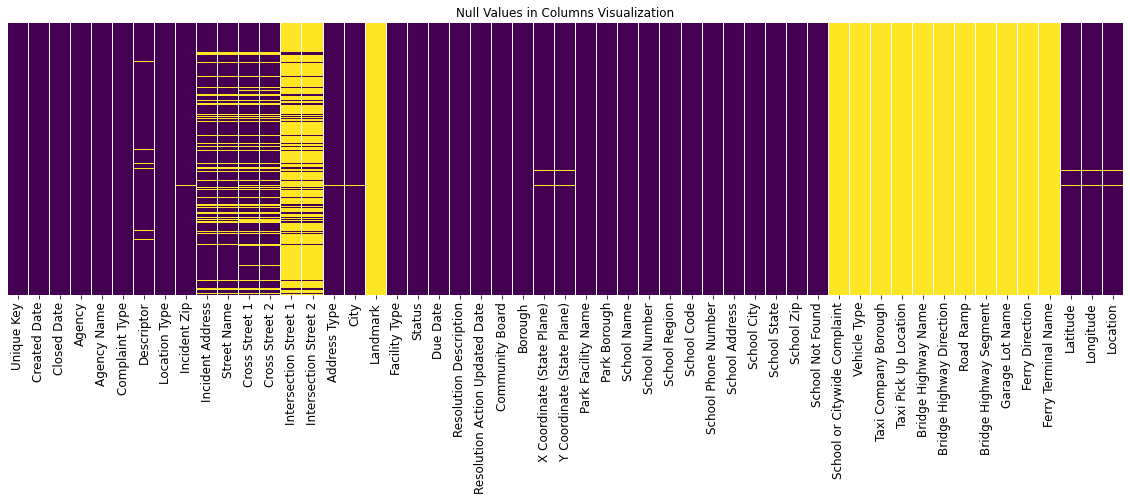

In [6]:
#visualize the null values using a heatmap
plt.figure(figsize=(20,5))
sns.heatmap(customer.isna(),cmap='viridis',cbar=False,yticklabels=False)
plt.title('Null Values in Columns Visualization')
plt.show()

The yellow bars represent the null values. There are multiple columns with completely null values. It would lead to wrong data analysis if it is imputed with some values without consulting the right source from where the data was generated. 

## *Exploratory Data Analysis & Data Cleaning*

In [7]:
#retrieve all the empty columns
empty_columns = []
for col in customer.columns:
    if customer[col].isna().sum() ==  len(customer):
        empty_columns.append(col)
print(empty_columns)        

['School or Citywide Complaint', 'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location', 'Garage Lot Name']


In [8]:
#drop the empty columns
customer.drop(empty_columns,axis=1,inplace=True)

In [9]:
#check the new shape after columns are dropped 
customer.shape

(300698, 48)

In [10]:
#check for exact duplicates
len(customer[customer.duplicated()==True])

0

There are no duplicate rows in the dataset. 

In [11]:
#convert the date columns from object to datetime format
customer['Created Date'] =  pd.to_datetime(customer['Created Date'])
customer['Closed Date'] = pd.to_datetime(customer['Closed Date'])

In [12]:
customer.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,32310363,2015-12-31 23:59:45,2016-01-01 00:55:00,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10034.0,71 VERMILYEA AVENUE,VERMILYEA AVENUE,ACADEMY STREET,WEST 204 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,01-01-16 7:59,The Police Department responded and upon arriv...,01-01-16 0:55,12 MANHATTAN,MANHATTAN,1005409.0,254678.0,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.865682,-73.923501,"(40.86568153633767, -73.92350095571744)"
1,32309934,2015-12-31 23:59:44,2016-01-01 01:26:00,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11105.0,27-07 23 AVENUE,23 AVENUE,27 STREET,28 STREET,NaN,NaN,ADDRESS,ASTORIA,NaN,Precinct,Closed,01-01-16 7:59,The Police Department responded to the complai...,01-01-16 1:26,01 QUEENS,QUEENS,1007766.0,221986.0,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.775945,-73.915094,"(40.775945312321085, -73.91509393898605)"


<b> *The entire dataset is from New York city and hence there won't be issue of time zones when determining the Resolution time.* </b>

In [13]:
#create a new column to represent the duration of the request closure
customer['Request_Closing_Time'] = abs(customer['Closed Date'] - customer['Created Date'])

In [14]:
customer[['Created Date','Closed Date','Request_Closing_Time']].head()

,Created Date,Closed Date,Request_Closing_Time
0,2015-12-31 23:59:45,2016-01-01 00:55:00,00:55:15
1,2015-12-31 23:59:44,2016-01-01 01:26:00,01:26:16
2,2015-12-31 23:59:29,2016-01-01 04:51:00,04:51:31
3,2015-12-31 23:57:46,2016-01-01 07:43:00,07:45:14
4,2015-12-31 23:56:58,2016-01-01 03:24:00,03:27:02


In [15]:
#maximum closing time
customer['Request_Closing_Time'].max()

Timedelta('24 days 16:52:22')

In [16]:
#minimum closing time
customer['Request_Closing_Time'].min()

Timedelta('0 days 00:01:00')

In [17]:
#Complaint whihc was closed in record time of 1 min .. 
customer[customer['Request_Closing_Time'] == customer['Request_Closing_Time'].min()]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,Request_Closing_Time
61125,31882332,2015-11-01 01:41:00,2015-11-01 01:42:00,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10003.0,78 EAST 4 STREET,EAST 4 STREET,BOWERY,2 AVENUE,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,11-01-15 9:41,The Police Department responded to the complai...,11-01-15 1:42,03 MANHATTAN,MANHATTAN,987021.0,203932.0,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.726422,-73.990003,"(40.726422494913116, -73.9900025591503)",00:01:00


In [18]:
#check the complaint description
print(customer[customer['Request_Closing_Time'] == customer['Request_Closing_Time'].min()]['Resolution Description'])

61125    The Police Department responded to the complai...
Name: Resolution Description, dtype: object


Alright, so this was a loud noise coming from a commercial place like bar, restaurant which the NYPD resolved it in a minute. Perhaps, it only needed a phone call to this place.

In [19]:
#Complaint which had the highest resolution time .. 
customer[customer['Request_Closing_Time'] == customer['Request_Closing_Time'].max()]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,Request_Closing_Time
244488,30684975,2015-05-23 23:51:59,2015-06-17 16:44:21,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11238.0,NaN,NaN,NaN,NaN,QUINCY STREET,CLASSON AVENUE,INTERSECTION,BROOKLYN,NaN,Precinct,Closed,05/24/2015 07:51:59 AM,The Police Department responded to the complai...,05/24/2015 02:03:29 AM,02 BROOKLYN,BROOKLYN,995504.0,189189.0,Unspecified,BROOKLYN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.68595,-73.959422,"(40.68594971751218, -73.95942153955151)",24 days 16:52:22


This one is strange. The complaint type is Noise from street or sidewalk and it took over 24 days for NYPD to resolve. The descriptor mentions it was Loud Music/ Party. The place has two intersection streets as well.

In [20]:
#number of agencies to which the complaints were assigned
customer['Agency'].value_counts().sort_values(ascending=False)

NYPD    300698
Name: Agency, dtype: int64

In [21]:
#check the agency names
customer['Agency Name'].value_counts().sort_values(ascending=False)

New York City Police Department    300690
Internal Affairs Bureau                 6
NYPD                                    2
Name: Agency Name, dtype: int64

<b> *Barring 6, all the rest were assigned to NYPD.* </b>

In [22]:
#check the basic stats of the complaint resolution time 
customer['Request_Closing_Time'].describe()

count                    298534
mean     0 days 04:18:51.832782
std      0 days 06:05:22.141833
min             0 days 00:01:00
25%             0 days 01:16:33
50%      0 days 02:42:55.500000
75%             0 days 05:21:00
max            24 days 16:52:22
Name: Request_Closing_Time, dtype: object

The median resolution time is just under 3 hours and the average is under 4.5 hours. 

In [23]:
#check the top 10 complaint types
top_10 = customer['Complaint Type'].value_counts().sort_values(ascending=False)[:10]

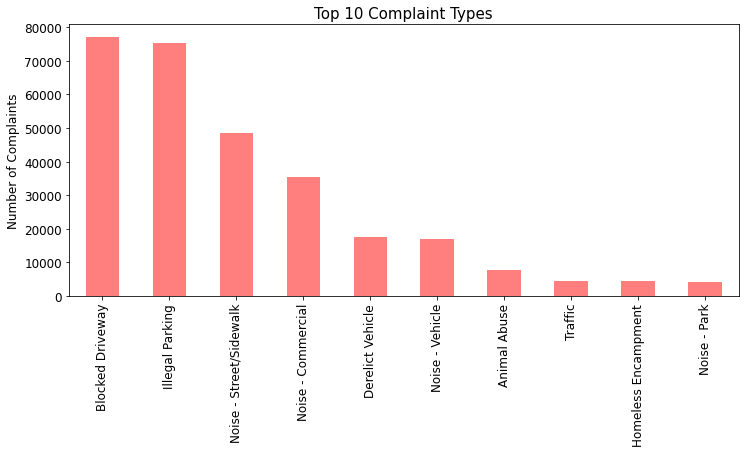

In [24]:
top_10.plot(kind='bar',color='red',alpha=0.5)
plt.title('Top 10 Complaint Types',size=15)
plt.ylabel('Number of Complaints')
plt.show()

Blocked Driveway, Illegal Parking, Noise constitute the maximum number of complaint types.

In [25]:
#check the status of all the complaint types
status = customer['Status'].value_counts().sort_values(ascending=False)

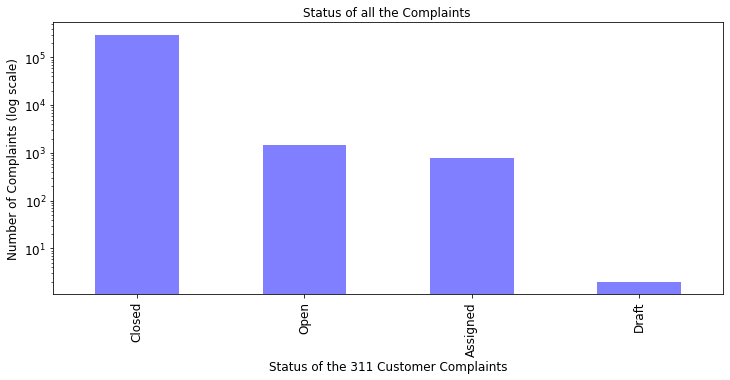

In [26]:
status.plot(kind='bar',alpha=0.5,color='b')
plt.title('Status of all the Complaints ')
plt.ylabel('Number of Complaints (log scale)')
plt.xlabel('Status of the 311 Customer Complaints')
plt.yscale('log')
plt.show()

In [27]:
status

Closed      298471
Open          1439
Assigned       786
Draft            2
Name: Status, dtype: int64

Almost all the complaints are closed. In the further section, lets explore the complaints which are open and assigned.

In [28]:
#check the open customer complaints
open_complaints = customer[customer['Status']== 'Open']

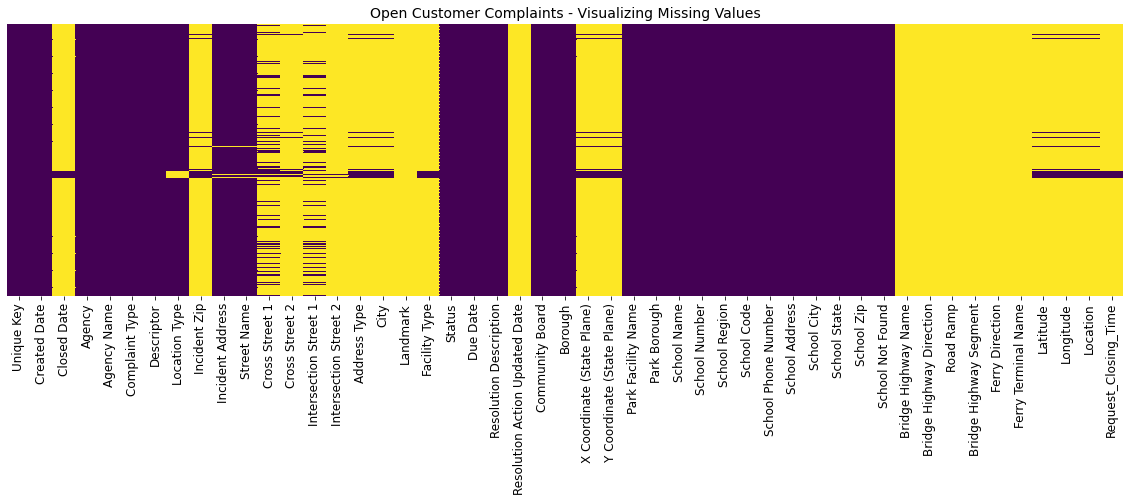

In [29]:
plt.figure(figsize=(20,5))
sns.heatmap(open_complaints.isna(),cbar=False,yticklabels=False,cmap='viridis')
plt.title('Open Customer Complaints - Visualizing Missing Values',size=14)
plt.show()

Many of the columns are empty in this subset of the dataset as well. One thing which stands out is there are a few rows in Closed Date which already have a value. As these are open customer complaints, it is not expected to have a closed date. Let's explore those specific rows. This would also break all the analysis done earlier to come out with the average time to close a complaint. All these open complaints have been assigned to an Agency (all are non null), have a complaint type as well. <b> Likely, that the status of these tickets are not updated. </b>

### *Sanity Checks - Complaint Status as Open but have a Closed Date*

In [30]:
#check len of the open complaints which have a closed date as not missing
len(open_complaints[~open_complaints['Closed Date'].isna()])

36

In [31]:
#check a few rows which have status open but have a closed date
open_complaints_closed = open_complaints[~open_complaints['Closed Date'].isna()]
open_complaints_closed.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,Request_Closing_Time
175920,31125954,2015-07-21 16:06:51,2015-07-21 17:57:57,NYPD,New York City Police Department,Posting Advertisement,Vehicle,NaN,10472.0,NaN,NaN,NaN,NaN,BOYNTON AVENUE,WATSON AVENUE,INTERSECTION,BRONX,NaN,Precinct,Open,07/22/2015 12:06:51 AM,The Police Department responded to the complai...,NaN,09 BRONX,BRONX,1018110.0,240290.0,Unspecified,BRONX,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.826151,-73.877654,"(40.82615116376492, -73.87765398540142)",01:51:06
175922,31131333,2015-07-21 16:03:48,2015-07-21 17:43:17,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,NaN,11432.0,159-27 JAMAICA AVENUE,JAMAICA AVENUE,PARSONS BOULEVARD,160 STREET,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Open,07/22/2015 12:03:48 AM,The Police Department responded to the complai...,NaN,12 QUEENS,QUEENS,1039744.0,195639.0,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.703487,-73.799853,"(40.703486614183255, -73.79985291056661)",01:39:29
175923,31128375,2015-07-21 15:58:54,2015-07-21 16:46:52,NYPD,New York City Police Department,Homeless Encampment,NaN,NaN,10025.0,37 WEST 95 STREET,WEST 95 STREET,CENTRAL PARK WEST,COLUMBUS AVENUE,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Open,07/21/2015 11:58:54 PM,The Police Department responded to the complai...,NaN,07 MANHATTAN,MANHATTAN,993574.0,227637.0,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.791482,-73.966327,"(40.79148216598658, -73.96632723419224)",00:47:58
175925,31133752,2015-07-21 15:55:24,2015-07-22 02:18:24,NYPD,New York City Police Department,Noise - Park,Loud Music/Party,NaN,11211.0,NaN,NaN,NaN,NaN,SHARON STREET,MORGAN AVENUE,INTERSECTION,BROOKLYN,NaN,Precinct,Open,07/21/2015 11:55:24 PM,The Police Department responded and upon arriv...,NaN,01 BROOKLYN,BROOKLYN,1002099.0,199846.0,Unspecified,BROOKLYN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.715190,-73.935614,"(40.71518983950294, -73.93561376221918)",10:23:00
175926,31132445,2015-07-21 15:54:15,2015-07-21 20:44:13,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,NaN,10036.0,1585 BROADWAY,BROADWAY,BROADWAY,8 AVENUE,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Open,07/21/2015 11:54:15 PM,The Police Department responded to the complai...,NaN,05 MANHATTAN,MANHATTAN,988313.0,216244.0,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.760215,-73.985334,"(40.760215360467875, -73.98533373855116)",04:49:58


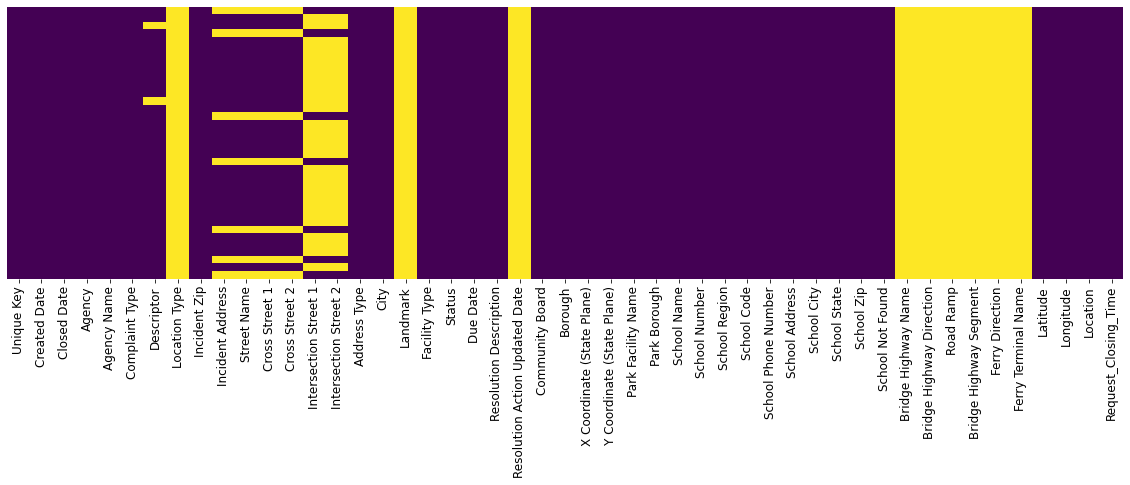

In [32]:
#visualise the columns of the open complaints which are marked on closed date
plt.figure(figsize=(20,5))
sns.heatmap(open_complaints_closed.isna(),cmap='viridis',cbar=False,yticklabels=False)
plt.show()

The location type is missing for all the rows. Some of the other key location attributes like Street name, Incident address. However, whatever seen as null is not null here. Example all related to School. 

In [33]:
open_complaints_closed['School Name'].value_counts()

Unspecified    36
Name: School Name, dtype: int64

In [34]:
customer['School Name'].value_counts()

Unspecified                        300697
Alley Pond Park - Nature Center         1
Name: School Name, dtype: int64

<b> Okay, so instead of missing these have value as Unspecified that these represent as missing. </b>

In [35]:
#change the status to Closed for all these rows
row_loc = customer[(customer['Status'] == 'Open') & (~customer['Closed Date'].isna())].index
#use this method for assignment to prevent SettingwithCopy warning
customer.loc[row_loc,'Status'] = 'Closed' 

In [36]:
#do similar exercise on the Assigned and Draft
customer[(customer['Status']=='Open') & (~customer['Closed Date'].isna())]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,Request_Closing_Time


In [37]:
customer[(customer['Status']=='Draft') & (~customer['Closed Date'].isna())]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,Request_Closing_Time
175921,31129107,2015-07-21 16:05:39,2015-07-21 21:56:38,NYPD,NYPD,Blocked Driveway,No Access,NaN,11219.0,1364 64 STREET,64 STREET,13 AVENUE,14 AVENUE,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Draft,NaN,The Police Department responded to the complai...,NaN,10 BROOKLYN,BROOKLYN,984371.0,167262.0,Unspecified,BROOKLYN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.625772,-73.999564,"(40.625772059824854, -73.999564104631)",05:50:59


In [38]:
#Change the status to Closed
customer.loc[175921,'Status'] = 'Closed'

In [39]:
customer.loc[[175921]]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,Request_Closing_Time
175921,31129107,2015-07-21 16:05:39,2015-07-21 21:56:38,NYPD,NYPD,Blocked Driveway,No Access,NaN,11219.0,1364 64 STREET,64 STREET,13 AVENUE,14 AVENUE,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,NaN,The Police Department responded to the complai...,NaN,10 BROOKLYN,BROOKLYN,984371.0,167262.0,Unspecified,BROOKLYN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,40.625772,-73.999564,"(40.625772059824854, -73.999564104631)",05:50:59


<b> *Now the data is clean with respect to the Status column and the Closed Date. There are no complaints which have a status value as Open, Assigned, Draft but are already closed based on the Closed Date.*

## *Turn Around Time to Close based on Complaint Type*

In [40]:
#create a copy of the cleaned dataset so far .. 
cust = customer.copy()

In [41]:
#new column with the close time in hours
cust['Close Time'] = cust['Request_Closing_Time'].dt.total_seconds() / (60 * 60)
cust['Close Time'].round(1)
pd.pivot_table(cust,values='Close Time',index='Complaint Type',aggfunc='median').sort_values(by='Close Time',
                                                                                           ascending=False)

,Close Time
Complaint Type,
Animal in a Park,336.834722
Agency Issues,4.904722
Graffiti,4.533333
Derelict Vehicle,4.116667
Squeegee,4.108333
Animal Abuse,3.300000
Blocked Driveway,3.166667
Illegal Parking,2.933333
Homeless Encampment,2.850000


Complaint Types of 'Animals in a Park', Agency Issues 'Derelict Vehicle', 'Graffiti' are the top 4 in terms of maximum median time to close. 
On the flip side, Posting Advertisement, Illegal Fireworks, Noise from the House of Worship takes the least time to close. 

In [42]:
#check the Animal in a Park complaints
cust[cust['Complaint Type']=='Animal in a Park']

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,Request_Closing_Time,Close Time
283132,30427220,2015-04-18 09:44:55,2015-05-02 10:35:00,NYPD,New York City Police Department,Animal in a Park,Animal Waste,Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUEENS,NaN,NaN,Closed,05-02-15 9:44,The condition was determined to be an issue ap...,05-02-15 10:35,0 Unspecified,Unspecified,NaN,NaN,Alley Pond Park - Nature Center,Unspecified,Alley Pond Park - Nature Center,Q001,NaN,NaN,7182176034,"Grand Central Parkway, near the soccer field",QUEENS,NY,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14 days 00:50:05,336.834722


There is just a single occurrence of this complaint type. This alone cannot be a good representative of the average time to close the complaint type. 

In [43]:
#save the dataset to a new csv file for faster operation in a separate notebook
cust.to_csv('customer_clean.csv',index=False)

## *Four Major Conclusions based on the Generic Data Analysis*

1. *Blocked Driveway is the top complaint type. The plot in the earlier section of the notebook lists the top 10 customer complaint types.* 

2. *Agency issues, Derelict Vehicle and Graffiti takes the maximum resolution time.* 

3. *99% of the complaints are assigned to NYPD and only 6 of the total complaints are assigned to Internal Affairs Bureau*

4. *There are complaints which had the status as open but had the closed date mentioned. This was perhaps due to the non update of the status column. The data was cleaned before coming out with the above conclusions.*

5. <b>*There are hardly any complaints associated with the School and the related columns of School had no entries.*</b>